In [1]:
from Utils import *

2023-07-23 14:38:25.952334: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 14:38:27.423816: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
import os, time, warnings

In [ ]:
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_loss', min_delta=0, patience=5, mode='auto'):
        super(CustomEarlyStopping, self).__init__()
        self.monitor = monitor        # Metric to monitor (e.g., 'val_loss', 'val_accuracy', 'loss', 'accuracy', etc.)
        self.min_delta = min_delta    # Minimum change in the monitored metric to be considered as improvement
        self.patience = patience      # Number of epochs with no improvement after which training will be stopped
        self.mode = mode              # 'auto', 'min', or 'max'. Determines the direction of improvement.
        self.best = None              # Variable to store the best monitored value
        self.stopped_epoch = 0        # Epoch at which training was stopped

        if self.mode == 'auto':
            if 'acc' in self.monitor:
                self.mode = 'max'
            else:
                self.mode = 'min'

    def on_train_begin(self, logs=None):
        self.best = float('inf') if self.mode == 'min' else float('-inf')

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            raise ValueError(f"Metric '{self.monitor}' not found in logs. Available metrics are: {logs.keys()}")

        if self.mode == 'min':
            improvement = current < self.best - self.min_delta
        else:
            improvement = current > self.best + self.min_delta

        if improvement:
            self.best = current
            self.stopped_epoch = epoch
        elif epoch - self.stopped_epoch > self.patience:
            self.model.stop_training = True
            print(f"\nEarly stopping as {self.monitor} did not improve for {self.patience} epochs.")
            
            
        # Create the custom early stopping callback
custom_early_stopping = CustomEarlyStopping(monitor='val_loss', 
                                            patience=10,
                                           mode='min')


In [2]:
len(fn)

1440

In [6]:
# load the audio file
file_name = fn[0]
def get_feature(file_name):
    audio, sample_rate = librosa.load(file_name, 
                                      # res_type="kaiser_fast"
                                     )
    # extract the features
    feature = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128)
    # feature scaling
    scaled_feature = np.mean(feature.T, axis=0)
    return scaled_feature

In [5]:
len(scaled_feature)

128

In [7]:
from tqdm import tqdm

# Initialize empty lists
male_features = []
male_labels = []
female_features = []
female_labels = []

# Use tqdm to track progress
for curr_file in tqdm(fn, desc="Processing files", 
                      unit="file"):
    curr_feat = get_feature(curr_file)
    curr_meta = get_metadata(curr_file)
    if curr_meta[1] == 'male':
        male_features.append(curr_feat)
        male_labels.append(curr_meta[0])
    else:
        female_features.append(curr_feat)
        female_labels.append(curr_meta[0])

Processing files: 100%|██████████████████████████████| 1440/1440 [01:38<00:00, 14.61file/s]


In [8]:
len(male_labels)

720

In [9]:
male_labels[:3]

['neutral', 'neutral', 'neutral']

In [10]:
len(male_features)

720

In [12]:
len(male_features[0])

128

In [14]:
# Define the list of possible values
possible_values = list(set(male_labels))

# Your list of strings to be encoded
# input_strings = ['happy', 'sad', 'angry', 'calm']

# Create a mapping from each value to its index
value_to_index = {value: index for index, value in enumerate(possible_values)}

# Map each string to its corresponding index
encoded_indices = [value_to_index[string] for string in male_labels]

# Perform one-hot encoding
one_hot_matrix = tf.one_hot(indices=encoded_indices, depth=len(possible_values))

# Convert the TensorFlow tensor to a NumPy array (optional)
male_labels_en = one_hot_matrix.numpy()

2023-07-23 14:47:21.905345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-23 14:47:22.075486: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [16]:
male_labels_en[10]

array([0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [19]:
import numpy as np

# Convert them to numpy arrays
male_features = np.array(male_features)
male_labels_en = np.array(male_labels_en)

In [27]:
# print the details
print("Number of training samples = ", male_features_train.shape)
print("Number of testing samples = ", male_labels_train_en.shape)

Number of training samples =  (482, 128)
Number of testing samples =  (482, 8)


In [20]:
from sklearn.model_selection import train_test_split

male_features_train, male_features_test, male_labels_train_en, male_labels_test_en = train_test_split(
    male_features, male_labels_en, test_size=0.33, random_state=42)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 1000)              129000    
                                                                 
 dense_15 (Dense)            (None, 750)               750750    
                                                                 
 dense_16 (Dense)            (None, 500)               375500    
                                                                 
 dense_17 (Dense)            (None, 250)               125250    
                                                                 
 dense_18 (Dense)            (None, 100)               25100     
                                                                 
 dense_19 (Dense)            (None, 50)                5050      
                                                                 
 dense_20 (Dense)            (None, 8)                

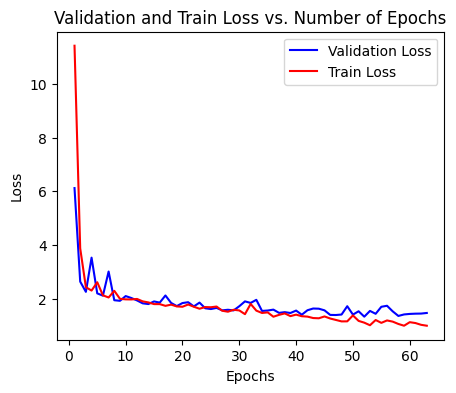

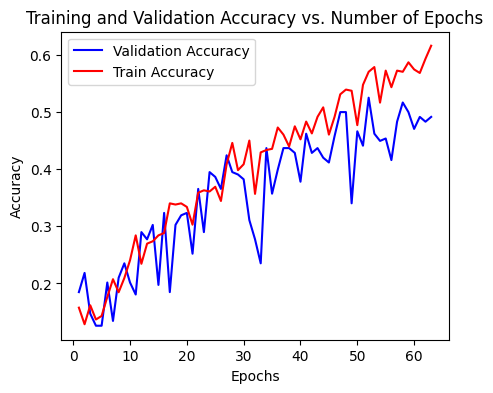

In [55]:
# Construct model
from keras import Sequential
from keras.layers import Dense

num_labels = male_labels_train_en.shape[1]
model = Sequential()
model.add(Dense(1000, activation="relu", input_shape=(128,)))
model.add(Dense(750, activation="relu"))
model.add(Dense(500, activation="relu"))
model.add(Dense(250, activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dense(50, activation="relu"))
model.add(Dense(num_labels, activation="softmax"))
print(model.summary())

model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)





num_epochs = 1000
num_batch_size = 32

# t0 = time.time()

history = model.fit(
    male_features_train,
    male_labels_train_en,
    batch_size=num_batch_size,
    epochs=num_epochs,
    validation_data=(male_features_test, male_labels_test_en),
    verbose=0,
    callbacks=[
              # early_stopping_callback, 
                     # lr_scheduler_callback
              custom_early_stopping,
                    ]
)



score = model.evaluate(x=male_features_test,y=male_labels_test_en, verbose=0)
print('Accuracy : ' + str(score[1]*100) + '%')


# Get the training history from the model.fit() call
history_dict = history.history

# Extract loss values from history
train_loss = history_dict['loss']
validation_loss = history_dict['val_loss']

# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot both validation loss and train loss on the same graph
plt.figure(figsize=(5, 4))
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.plot(epochs, train_loss, 'r', label='Train Loss')
plt.title('Validation and Train Loss vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Get the training history from the model.fit() call
history_dict = history.history

# Extract accuracy values from history
train_accuracy = history_dict['accuracy']
validation_accuracy = history_dict['val_accuracy']

# Get the number of epochs
epochs = range(1, len(train_accuracy) + 1)

# Plot both training accuracy and validation accuracy on the same graph
plt.figure(figsize=(5, 4))
plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.plot(epochs, train_accuracy, 'r', label='Train Accuracy')
plt.title('Training and Validation Accuracy vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Early stopping as val_loss did not improve for 10 epochs.
Accuracy : 42.016807198524475%


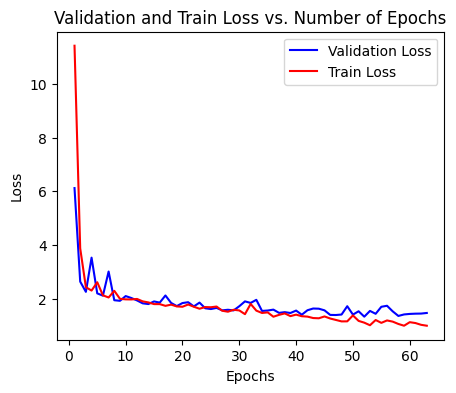

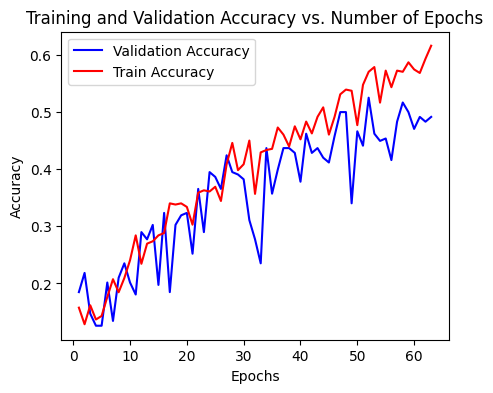

In [58]:
# Construct model
# model.add(Dense(1000, activation="relu", input_shape=(128,)))

inputs = tf.keras.Input(shape=(128,), name="feature")
x = tf.keras.layers.Dense(300, activation="relu", name="dense_1", 
                          # bias_regularizer=tf.keras.regularizers.l1(0.01),
                         )(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.1)(x)  # Adjust dropout rate as needed
x = tf.keras.layers.Dense(200, activation="relu", name="dense_2", 
                          # bias_regularizer=tf.keras.regularizers.l1(0.01),
                         )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.1)(x)  # Adjust dropout rate as needed
outputs = tf.keras.layers.Dense(8, activation="softmax", name="predictions", 
                               )(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),  # Adjust learning rate as needed
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

# early_stopping_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_categorical_accuracy',
#     patience=100,  # Increase patience if needed
#     mode='max',
#     verbose=1,
# )


# Create the custom early stopping callback
custom_early_stopping = CustomEarlyStopping(monitor='val_loss', 
                                            patience=10,
                                           mode='min')





# Now you can use male_features_train_onehot and male_features_test_onehot for model training
model.fit(x=male_features_train, y=male_labels_train_en,
          verbose=0,  # Change to 1 for progress bar during training
          validation_data=(male_features_test, male_labels_test_en),
          epochs=1000,
          callbacks=[
              # early_stopping_callback, 
                     # lr_scheduler_callback
              custom_early_stopping,
                    ]
          )




score = model.evaluate(x=male_features_test,y=male_labels_test_en, verbose=0)
print('Accuracy : ' + str(score[1]*100) + '%')


# Get the training history from the model.fit() call
history_dict = history.history

# Extract loss values from history
train_loss = history_dict['loss']
validation_loss = history_dict['val_loss']

# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot both validation loss and train loss on the same graph
plt.figure(figsize=(5, 4))
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.plot(epochs, train_loss, 'r', label='Train Loss')
plt.title('Validation and Train Loss vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Get the training history from the model.fit() call
history_dict = history.history

# Extract accuracy values from history
train_accuracy = history_dict['accuracy']
validation_accuracy = history_dict['val_accuracy']

# Get the number of epochs
epochs = range(1, len(train_accuracy) + 1)

# Plot both training accuracy and validation accuracy on the same graph
plt.figure(figsize=(5, 4))
plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.plot(epochs, train_accuracy, 'r', label='Train Accuracy')
plt.title('Training and Validation Accuracy vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Accuracy : 62.60504126548767%


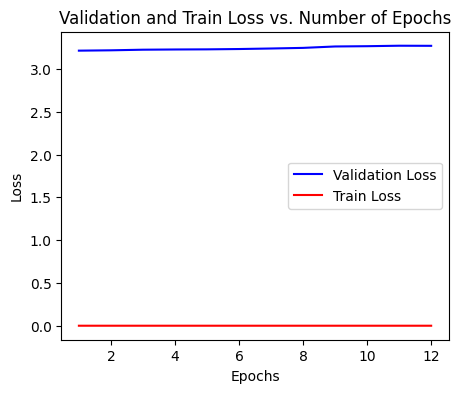

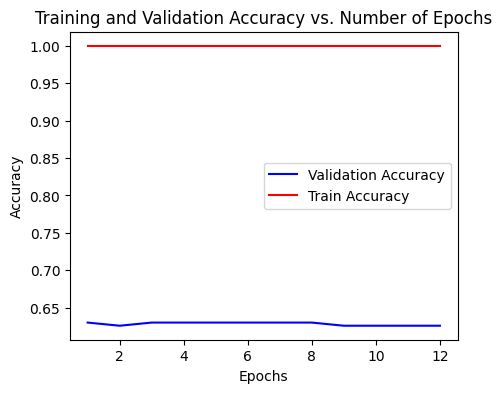

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 1000)              129000    
                                                                 
 dropout_18 (Dropout)        (None, 1000)              0         
                                                                 
 dense_36 (Dense)            (None, 750)               750750    
                                                                 
 dropout_19 (Dropout)        (None, 750)               0         
                                                                 
 dense_37 (Dense)            (None, 500)               375500    
                                                                 
 dropout_20 (Dropout)        (None, 500)               0         
                                                                 
 dense_38 (Dense)            (None, 250)              

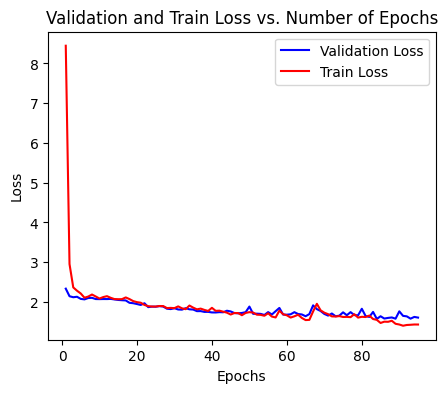

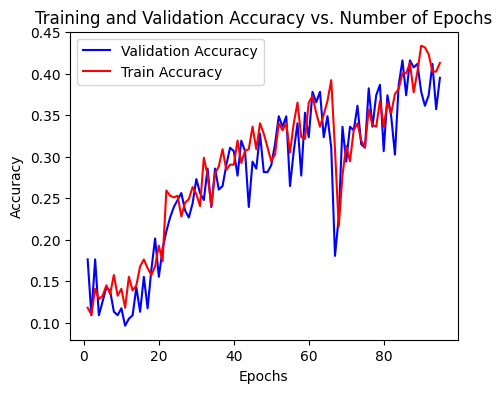

In [61]:
# Construct model
from keras import Sequential
from keras.layers import Dense

num_labels = male_labels_train_en.shape[1]
model = Sequential()
model.add(Dense(1000, activation="relu", input_shape=(128,)))
model.add(tf.keras.layers.Dropout(0.1)) # Adjust dropout rate as needed

model.add(Dense(750, activation="relu"))
model.add(tf.keras.layers.Dropout(0.1)) # Adjust dropout rate as needed

model.add(Dense(500, activation="relu"))
model.add(tf.keras.layers.Dropout(0.1)) # Adjust dropout rate as needed

model.add(Dense(250, activation="relu"))
model.add(tf.keras.layers.Dropout(0.1)) # Adjust dropout rate as needed

model.add(Dense(100, activation="relu"))
model.add(tf.keras.layers.Dropout(0.1)) # Adjust dropout rate as needed

model.add(Dense(50, activation="relu"))
model.add(tf.keras.layers.Dropout(0.1)) # Adjust dropout rate as needed

model.add(Dense(num_labels, activation="softmax"))
print(model.summary())

model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)





num_epochs = 1000
num_batch_size = 32

# t0 = time.time()

history = model.fit(
    male_features_train,
    male_labels_train_en,
    batch_size=num_batch_size,
    epochs=num_epochs,
    validation_data=(male_features_test, male_labels_test_en),
    verbose=0,
    callbacks=[
              # early_stopping_callback, 
                     # lr_scheduler_callback
              custom_early_stopping,
                    ]
)



score = model.evaluate(x=male_features_test,y=male_labels_test_en, verbose=0)
print('Accuracy : ' + str(score[1]*100) + '%')


# Get the training history from the model.fit() call
history_dict = history.history

# Extract loss values from history
train_loss = history_dict['loss']
validation_loss = history_dict['val_loss']

# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot both validation loss and train loss on the same graph
plt.figure(figsize=(5, 4))
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.plot(epochs, train_loss, 'r', label='Train Loss')
plt.title('Validation and Train Loss vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Get the training history from the model.fit() call
history_dict = history.history

# Extract accuracy values from history
train_accuracy = history_dict['accuracy']
validation_accuracy = history_dict['val_accuracy']

# Get the number of epochs
epochs = range(1, len(train_accuracy) + 1)

# Plot both training accuracy and validation accuracy on the same graph
plt.figure(figsize=(5, 4))
plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.plot(epochs, train_accuracy, 'r', label='Train Accuracy')
plt.title('Training and Validation Accuracy vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [63]:
from tensorflow.keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 128, 256)          1536      
                                                                 
 batch_normalization_8 (Batc  (None, 128, 256)         1024      
 hNormalization)                                                 
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 64, 256)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 64, 256)           327936    
                                                                 
 dropout_32 (Dropout)        (None, 64, 256)           0         
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 32, 256)        

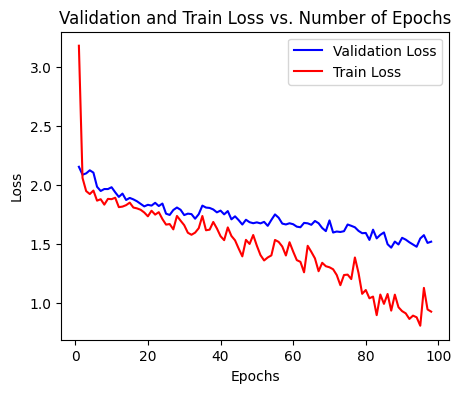

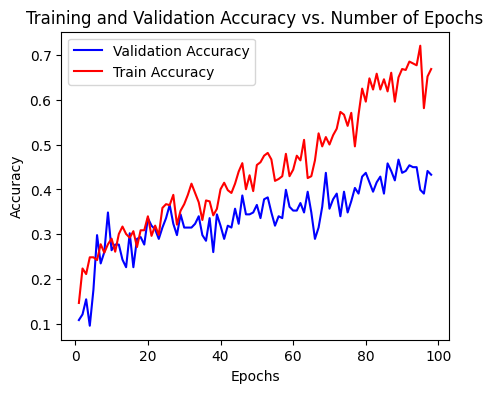

In [66]:
model = Sequential()
model.add(
    Conv1D(
        256,
        5,
        strides=1,
        padding="same",
        activation="relu",
        input_shape=(male_features_train.shape[1], 1),
    )
)
model.add(BatchNormalization())
model.add(MaxPooling1D(3, strides=2, padding="same"))
model.add(Conv1D(256, 5, strides=1, padding="same", activation="relu"))
model.add(Dropout(0.3))
model.add(MaxPooling1D(3, strides=2, padding="same"))
model.add(Conv1D(128, 5, strides=1, padding="same", activation="relu"))
model.add(Dropout(0.3))
model.add(MaxPooling1D(3, strides=2, padding="same"))
model.add(Conv1D(64, 5, strides=1, padding="same", activation="relu"))
model.add(Dropout(0.3))
model.add(MaxPooling1D(3, strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=1024, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=8, activation="softmax"))
model.summary()


model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)



num_epochs = 1000
num_batch_size = 32

# t0 = time.time()

history = model.fit(
    male_features_train,
    male_labels_train_en,
    batch_size=num_batch_size,
    epochs=num_epochs,
    validation_data=(male_features_test, male_labels_test_en),
    verbose=0,
    callbacks=[
              # early_stopping_callback, 
                     # lr_scheduler_callback
              custom_early_stopping,
                    ]
)



score = model.evaluate(x=male_features_test,y=male_labels_test_en, verbose=0)
print('Accuracy : ' + str(score[1]*100) + '%')


# Get the training history from the model.fit() call
history_dict = history.history

# Extract loss values from history
train_loss = history_dict['loss']
validation_loss = history_dict['val_loss']

# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot both validation loss and train loss on the same graph
plt.figure(figsize=(5, 4))
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.plot(epochs, train_loss, 'r', label='Train Loss')
plt.title('Validation and Train Loss vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Get the training history from the model.fit() call
history_dict = history.history

# Extract accuracy values from history
train_accuracy = history_dict['accuracy']
validation_accuracy = history_dict['val_accuracy']

# Get the number of epochs
epochs = range(1, len(train_accuracy) + 1)

# Plot both training accuracy and validation accuracy on the same graph
plt.figure(figsize=(5, 4))
plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.plot(epochs, train_accuracy, 'r', label='Train Accuracy')
plt.title('Training and Validation Accuracy vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [70]:
import os
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Function to extract audio features using librosa
def extract_audio_features(file_path):
    # Load the audio file using librosa
    audio, sr = librosa.load(file_path, sr=None)

    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfccs_scaled = np.mean(mfccs.T, axis=0)

    return mfccs_scaled


# Function to create a TensorFlow model for audio classification
def create_audio_classification_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model



In [71]:
len(male_labels_test_en[0])

8

In [72]:
male_labels_test_en[0]

array([0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [74]:
len(male_features_test[0])

128

In [76]:
# Define the number of classes for the audio classification problem
num_classes = len(np.unique(male_labels))
num_classes

8

Accuracy : 34.873950481414795%


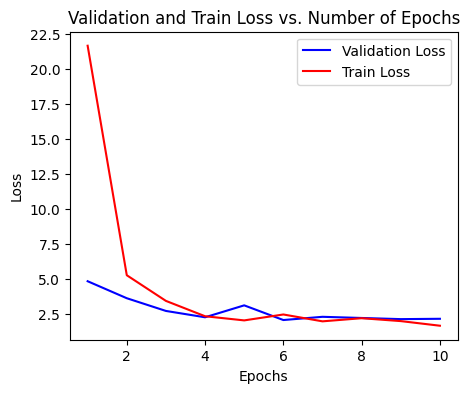

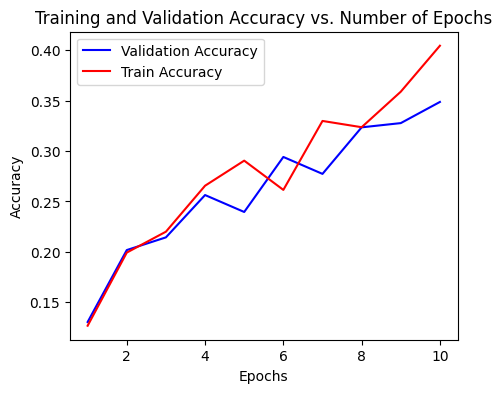

In [88]:
# Create the TensorFlow model
model = create_audio_classification_model(input_shape=male_features_train[0].shape, num_classes=num_classes)

# Compile the model with categorical_crossentropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with one-hot encoded labels
history = model.fit(male_features_train, male_labels_train_en, verbose=0, epochs=10,
                        validation_data=(male_features_test, male_labels_test_en),
batch_size=32)

# Get the training history from the model.fit() call
history_dict = history.history

# Extract loss values from history
train_loss = history_dict['loss']
validation_loss = history_dict['val_loss']

# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

score = model.evaluate(x=male_features_test,y=male_labels_test_en, verbose=0)
print('Accuracy : ' + str(score[1]*100) + '%')

# Plot both validation loss and train loss on the same graph
plt.figure(figsize=(5, 4))
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.plot(epochs, train_loss, 'r', label='Train Loss')
plt.title('Validation and Train Loss vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Get the training history from the model.fit() call
history_dict = history.history

# Extract accuracy values from history
train_accuracy = history_dict['accuracy']
validation_accuracy = history_dict['val_accuracy']

# Get the number of epochs
epochs = range(1, len(train_accuracy) + 1)

# Plot both training accuracy and validation accuracy on the same graph
plt.figure(figsize=(5, 4))
plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.plot(epochs, train_accuracy, 'r', label='Train Accuracy')
plt.title('Training and Validation Accuracy vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [86]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [107]:
from tqdm import tqdm

# Initialize empty lists
male_features = []
# male_labels = []
# female_features = []
# female_labels = []

def get_feature(audio_file, n_mfcc=13, n_fft=2048, hop_length=512):
    """
    Extract MFCC features from an audio file.

    Parameters:
        audio_file (str): Path to the audio file.
        n_mfcc (int): Number of MFCC coefficients to extract.
        n_fft (int): Length of the FFT window.
        hop_length (int): Hop length (number of samples) between frames.

    Returns:
        mfcc_features (np.ndarray): Extracted MFCC features.
    """
    y, sr = librosa.load(audio_file)
    mfcc_features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    return mfcc_features

# Use tqdm to track progress
for curr_file in tqdm(fn, desc="Processing files", 
                      unit="file"):
    curr_feat = get_feature(curr_file)
    curr_meta = get_metadata(curr_file)
    if curr_meta[1] == 'male':
        male_features.append(curr_feat)
        # male_labels.append(curr_meta[0])
    # else:
    #     female_features.append(curr_feat)
    #     female_labels.append(curr_meta[0])

Processing files: 100%|██████████████████████████████| 1440/1440 [01:49<00:00, 13.17file/s]


In [108]:
from sklearn.model_selection import train_test_split

male_features_train, male_features_test, male_labels_train_en, male_labels_test_en = train_test_split(
    male_features, male_labels_en, test_size=0.33, random_state=42)



In [120]:
# male_features_train = np.expand_dims(male_features_train, axis=-1)
# male_features_test = np.expand_dims(male_features_test, axis=-1)

# Build the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=male_features_train[0].shape[1:]),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_labels, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(male_features_train, male_labels_train_en, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(male_features_test, male_labels_test_onehot)
print(f'Test accuracy: {test_accuracy}')

ValueError: Input 0 of layer "conv2d_12" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 164)

In [102]:
len(male_features_train[0])

182583

In [106]:
len(male_features)

0

In [117]:
male_features_train[0].shape

(13, 164)